# Environnement jupyter

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importation des librairies utilisées

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Données étudiées

In [3]:
dataset = pd.read_csv("Run_Questionnaire/DataSetTotal.csv")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Q1              227 non-null    object
 1   Q2              223 non-null    object
 2   Q3              222 non-null    object
 3   Q4              225 non-null    object
 4   Q5              221 non-null    object
 5   Q6              223 non-null    object
 6   Q7              225 non-null    object
 7   Q8              222 non-null    object
 8   Q9              225 non-null    object
 9   Q10             227 non-null    object
 10  Score           235 non-null    int64 
 11  Interpretation  235 non-null    object
dtypes: int64(1), object(11)
memory usage: 22.2+ KB


#  Prétraitement

## Erreurs de saisie corrigibles

In [5]:
for column in dataset.columns:
        dataset[column] = dataset[column].astype(str).str.lower()

## Remplacement par des NaN

In [6]:
# On définit les valeurs qu'il est possible de remplacer avec des valeurs correctes
listValA = ["(a)", "1"]
listValB = ["(b)", "2"]
listValC = ["(c)", "3"]
listVal1 = ["(1)", "a", "1.0", "(a)"]
listVal2 = ["(2)", "b", "2.0", "(b)"]
listVal3 = ["(3)", "c", "3.0", "(c)"]

# On différencie les colonnes en fonction des réponses attendues
for column in dataset.columns:
    if column in ["Q1", "Q2", "Q3", "Q4", "Q5"]:

        # On remplace les valeurs proches des réponses attendues (a, b ou c)
        dataset[column] = dataset[column].replace(
            to_replace=listValA, value="a")
        dataset[column] = dataset[column].replace(
            to_replace=listValB, value="b")
        dataset[column] = dataset[column].replace(
            to_replace=listValC, value="c")

        # On remplace les valeurs restantes par des NaN
        listValNan = dataset[column].unique()
        listValNan = [
            val for val in listValNan if val not in ("a", "b", "c")]
        dataset[column] = dataset[column].replace(listValNan, np.nan)
        #TODO: Possibilité d'utilitser isin() ?

    elif column in ["Q6", "Q7", "Q8", "Q9", "Q10"]:

        # On remplace les valeurs proches des réponses attendues (1, 2 ou 3)
        dataset[column] = dataset[column].replace(
            to_replace=listVal1, value="1")
        dataset[column] = dataset[column].replace(
            to_replace=listVal2, value="2")
        dataset[column] = dataset[column].replace(
            to_replace=listVal3, value="3")

        # On remplace les valeurs restantes par des NaN
        listValNan = dataset[column].unique()
        listValNan = [
            val for val in listValNan if val not in ("1", "2", "3")]
        dataset[column] = dataset[column].replace(listValNan, np.nan)

## Remplacement des NaN par le mode

In [7]:
dataset = dataset.apply(lambda x:x.fillna(x.value_counts().index[0])) # Le mode ne fonctionne pas vu que l'on a plus de valeur NaN que les autres

## Recalcul du Score

In [8]:
scores = []
interpretations = []
lignes, colonnes = dataset.shape

for ligne in range(lignes):
    score = 0
    for colonne in range(colonnes):
        valeur = dataset.iloc[ligne, colonne]
        if valeur == 'a' or valeur == '1':
            score += 1
        elif valeur == 'b' or valeur == '2':
            score += 0
        elif valeur == 'c' or valeur == '3':
            score += 2

    scores.append(score)

    if score < 30 and score >=20:
        label = 'A'
    elif score < 20 and score >=10:
        label = 'B'
    elif score < 10:
        label = 'C'

    interpretations.append(label)

dataset["Score"] = scores
dataset["Interpretation"] = interpretations

## Encodage des valeurs catégorielles

In [9]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

for column in dataset.columns:
    if column not in ["Score", "Interpretation"]:
        dataset[column] = labelEncoder.fit_transform(dataset[column])

## Données prétraitées

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Q1              235 non-null    int32 
 1   Q2              235 non-null    int32 
 2   Q3              235 non-null    int32 
 3   Q4              235 non-null    int32 
 4   Q5              235 non-null    int32 
 5   Q6              235 non-null    int32 
 6   Q7              235 non-null    int32 
 7   Q8              235 non-null    int32 
 8   Q9              235 non-null    int32 
 9   Q10             235 non-null    int32 
 10  Score           235 non-null    int64 
 11  Interpretation  235 non-null    object
dtypes: int32(10), int64(1), object(1)
memory usage: 13.0+ KB


# Séparation des données

In [11]:
from sklearn.model_selection import train_test_split

X = dataset[dataset.columns[:-2]]
y = dataset[dataset.columns[-1]]

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, shuffle=True)

# KNN from Scratch

## Fonction distance

In [12]:
def distance(X, Y, metric="euclidean", **kargs):

    if kargs.items():   # On commence par tester la présence d'arguments supplémentaires
        
        for key,value in kargs.items():
            if key == 'p' : # On récupère l'ordre de la métrique si elle est donnée en entrée par l'utilisateur
                p = value
    else :
        p = 3
    
    if metric == 'euclidean' :
        dis = np.sqrt(np.sum((X-Y)**2))
    elif metric == 'manhattan' :
        dis = np.abs(np.sum(X-Y))
    elif metric == 'minkowski':
            dis = (np.sum(np.abs(X-Y))**p)**(1/p)

    return dis

## Fonction modèle

In [32]:
def knn(X_train, X_test, y_train, k, metric) :
    
    resultat = []

    for j in range(len(X_test)):    # On parcourt le dataset de test
        distances = []

        d_T = X_test.iloc[j,:]  # On récupère chaque entrée du dataset

        for i in range(len(X_train)):   # On parcourt le dataset du train
            d_A = X_train.iloc[i,:] # On récupère chaque entrée du dataset
        
            dis = distance(d_T, d_A, metric=metric) # On calcule la distance entre ces deux entrées
            distances.append(dis)   # On enregistre la valeur de la distance

        indexDistanceTriees = np.argsort(distances)   # On récupère les index des distances triées

        index_petite_distance = indexDistanceTriees[:k] # On récupère les k premières valeurs

        Pred = y_train.iloc[index_petite_distance]  # On récupère les prédictions associées à ces valeurs

        Pred = [np.sum((Pred == 'A').astype(int)), np.sum((Pred == 'B').astype(int)), np.sum((Pred == 'C').astype(int))]    # On somme le nombre des prédictions efectuées par classe

        Pred = np.argmax(Pred)  # On récupère la valeur la plus présente parmis les k voisins

        if Pred == 0:
            P = 'A'
        elif Pred == 1 :
            P = 'B' 
        else : 
            P = 'C'
        
        resultat.append(P)  # On convertie les valeurs en nom de classe et on l'ajoute au résultat
        
    return resultat

## Expérimentation

In [14]:
from sklearn.metrics import accuracy_score

### Distance euclidienne

In [15]:
scoresEuclidean = []
index = []

for i in range(1, 15):
        if i%2 == 1:
            index.append(i)
            
            
            yPredEuclidean = knn(XTrain, XTest, yTrain, i, metric="euclidean")
            scoreEuclidean = accuracy_score(yTest, yPredEuclidean)
            
            print(f"Précision pour k={i} : {scoreEuclidean}")
            scoresEuclidean.append(scoreEuclidean)

Précision pour k=1 : 0.8723404255319149
Précision pour k=3 : 0.8723404255319149
Précision pour k=5 : 0.8936170212765957
Précision pour k=7 : 0.8723404255319149
Précision pour k=9 : 0.8936170212765957
Précision pour k=11 : 0.8936170212765957
Précision pour k=13 : 0.8723404255319149


### Distance manhattan

In [16]:
scoresManhattan = []
index = []

for i in range(1, 15):
        if i%2 == 1:
            index.append(i)
            
            
            yPredManhattan = knn(XTrain, XTest, yTrain, i, metric="manhattan")
            scoreManhattan = accuracy_score(yTest, yPredManhattan)
            
            print(f"Précision pour k={i} : {scoreManhattan}")
            scoresManhattan.append(scoreManhattan)

Précision pour k=1 : 0.6808510638297872
Précision pour k=3 : 0.7659574468085106
Précision pour k=5 : 0.7659574468085106
Précision pour k=7 : 0.7659574468085106
Précision pour k=9 : 0.7446808510638298
Précision pour k=11 : 0.7446808510638298
Précision pour k=13 : 0.8085106382978723


### Distance minkowski

In [17]:
scoresMinkowski = []
index = []

for i in range(1, 15):
        if i%2 == 1:
            index.append(i)
            
            
            yPredMinkowski = knn(XTrain, XTest, yTrain, i, metric="minkowski")
            scoreMinkowski = accuracy_score(yTest, yPredMinkowski)
            
            print(f"Précision pour k={i} : {scoreMinkowski}")
            scoresMinkowski.append(scoreMinkowski)

Précision pour k=1 : 0.9148936170212766
Précision pour k=3 : 0.8723404255319149
Précision pour k=5 : 0.8723404255319149
Précision pour k=7 : 0.9574468085106383
Précision pour k=9 : 0.9361702127659575
Précision pour k=11 : 0.9361702127659575
Précision pour k=13 : 0.9361702127659575


## Performances

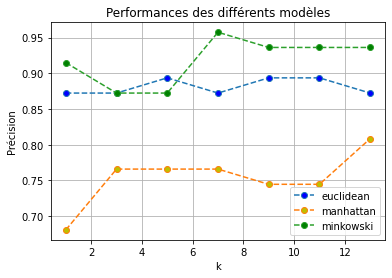

In [18]:
plt.plot(index, scoresEuclidean, linestyle='--', marker='o', markerfacecolor='b', label="euclidean")
plt.plot(index, scoresManhattan, linestyle='--', marker='o', markerfacecolor='y', label="manhattan")
plt.plot(index, scoresMinkowski, linestyle='--', marker='o', markerfacecolor='g', label="minkowski")

plt.title("Performances des différents modèles")
plt.xlabel("k")
plt.ylabel("Précision")
plt.grid()
plt.legend()
plt.show();

In [33]:
yPred = knn(XTrain, XTest, yTrain, 7, metric="minkowski")
    
accuracy = accuracy_score(yTest, yPred)*100
print(f"Précision : {accuracy:.2f}%")

Précision : 95.74%


## Matrice de confusion

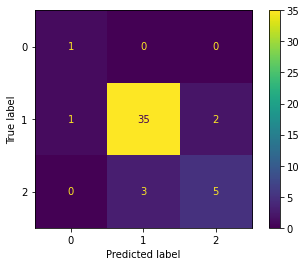

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(yTest, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

# KNN Sklearn

## Importation de la classe sklearn.neighbors

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

## Préparation des données

Les données ont déjà été préparées en amont de la partie KNN from Scratch (erreurs, remplacement par des NaN, remplacement par les modes et encodage des valeurs catégorielles).
On étudiera l'utilité de normaliser et de standardiser les valeurs (caractéristiques ou cibles ?).

In [22]:
from sklearn.preprocessing import MinMaxScaler

minMaxScaler = MinMaxScaler()

X = pd.DataFrame(minMaxScaler.fit_transform(X), columns=X.columns)

## K-fold validation

In [23]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    #print("\nTRAIN:", train_index, "\nTEST:", test_index)
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_pred, y_test)*100
    print(f"Précision : {accuracy:.2f}%")

3

KNeighborsClassifier()

Précision : 79.75%


KNeighborsClassifier()

Précision : 79.49%


KNeighborsClassifier()

Précision : 85.90%


## Gridsearch

La K-fold validation et l'hyperparamètrage sont fait au sein du Gridsearch, on n'étudiera pas plus en profondeur ces points.

In [24]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range, metric=["euclidean", "manhattan", "minkowski"])
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')
  
print(grid)
# fitting the model for grid search
grid_search=grid.fit(XTrain, yTrain)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')


In [25]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 9}

## Performances

In [26]:
from sklearn.metrics import accuracy_score

accuracy = grid_search.best_score_ *100
print("Précision pour le dataset d'entraînement après calibration : {:.2f}%".format(accuracy) ) 

Précision pour le dataset d'entraînement après calibration : 88.83%


In [27]:
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"], metric=grid_search.best_params_["metric"])

knn.fit(XTrain, yTrain)

y_test_hat=knn.predict(XTest) 

test_accuracy=accuracy_score(yTest,y_test_hat)*100

print("Précision pour le dataset de test après calibration : {:.2f}%".format(test_accuracy) ) 

KNeighborsClassifier(metric='manhattan', n_neighbors=9)

Précision pour le dataset de test après calibration : 93.62%


## Matrice de confusion

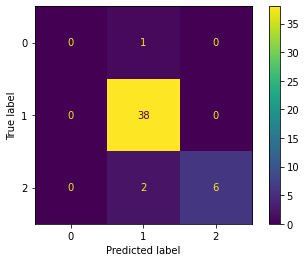

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(yTest, y_test_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [30]:
import joblib
joblib.dump(knn, 'ModeleKNN.pkl');

# Comparaison des résultats

Après comparaison des résultats entre KNN from Scratch et KNN Sklearn, on obtient des résultats comparables. Cependant après exécution de plusieurs modèles, la précision obtenue avec le KNN from Scratch est un peu meilleure et permet une meilleure prédiction des valeurs les moins fréquentes. Cela peut provenir du choix des hyperparamètres : pour le KNN from Scratch, ce choix est effectué manuellement après avoir réalisé différentes simulations, mais pour le KNN Sklearn, ce choix est effectué automatiquement suite à l'exécution d'un GridSearch. Ainsi, le modèle KNN from Scratch semble être mieux adapté à nos valeurs, mais peut être sujet à de la surinterprétation, alors que le modèle KNN Sklearn aura une meilleure prédiction sur de nouvelles valeurs.